In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")

In [2]:
mnist
X, y = mnist["data"], mnist["target"]

(-0.5, 27.5, 27.5, -0.5)

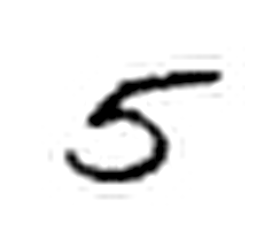

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36008]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="sinc")
plt.axis("off")

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [6]:
#Traning binary classifier for 5
y_train_5 = (y_train == 5.0)
y_test_5 = (y_test == 5.0)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [9]:
#Implementing Cross Validation by yourself
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state =42)
for train_index , test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.97005
0.96695
0.95105


In [10]:
#implementing k Cross Validation from sklearn package
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([ 0.97005,  0.96695,  0.95105])

In [11]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predict)

#Precision TP/(TP+FP)
#Recall or Sensitivity TP/(TP+FN)
#F1 Score 1/((1/Recall)+(1/Precision))

from sklearn.metrics import precision_score, recall_score
print("Precision Score:",precision_score(y_train_5, y_train_predict))
print("Recall Score:", recall_score(y_train_5, y_train_predict))

Precision Score: 0.920454545455
Recall Score: 0.642501383509


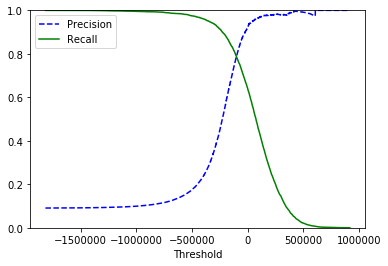

In [12]:
#Precision Recall Curves
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [13]:
precision_recall_curve(y_train_5, y_scores)

(array([ 0.09089537,  0.09088013,  0.09088165, ...,  1.        ,
         1.        ,  1.        ]),
 array([  1.00000000e+00,   9.99815532e-01,   9.99815532e-01, ...,
          3.68935621e-04,   1.84467810e-04,   0.00000000e+00]),
 array([-1817692.47444391, -1817115.59771801, -1817008.33364988, ...,
          871650.36629171,   892288.96824977,   918822.63259636]))

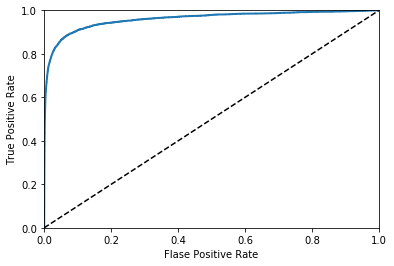

In [14]:
#ROC Curves
#Plots between TP Rate(Recall) vs FP Rate(1-Specificity(TN Rate))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth =2, label = label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1, 0,1])
    plt.xlabel('Flase Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95987170958175305

In [16]:
#MultiClass Classification
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [17]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-106424.11879834, -349355.60260998, -367422.36618076,
         -11449.3850843 , -174669.51904054,  131246.82055306,
        -601166.23991836, -270772.83594437, -294252.54438856,
        -341934.43198905]])

In [18]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

5
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
5.0


In [19]:
#Forcing linear classifier to use One vs One Stratergy
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

In [20]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [21]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring= "accuracy")

array([ 0.86727654,  0.83499175,  0.8673301 ])

In [22]:
#implementing scaling and then checking cross validation accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90591882,  0.91089554,  0.91018653])

In [23]:
#Error Analsis for multiclass classification problems
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5739,    4,   17,    9,   12,   47,   44,    8,   39,    4],
       [   1, 6457,   50,   25,    6,   40,    8,   13,  130,   12],
       [  56,   34, 5332,  109,   82,   28,   78,   60,  160,   19],
       [  44,   42,  129, 5343,    2,  241,   39,   50,  142,   99],
       [  19,   24,   35,    8, 5353,   10,   52,   31,   94,  216],
       [  61,   42,   33,  185,   65, 4625,  105,   26,  181,   98],
       [  31,   28,   52,    2,   41,  101, 5605,   12,   45,    1],
       [  21,   21,   71,   34,   50,   10,    5, 5773,   17,  263],
       [  48,  146,   62,  168,   14,  170,   51,   25, 5035,  132],
       [  41,   31,   24,   86,  153,   41,    2,  209,   84, 5278]])

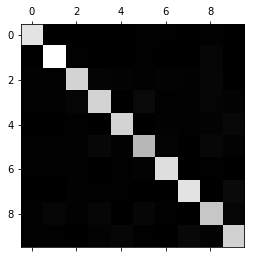

In [24]:
plt.matshow(conf_mx, cmap= plt.cm.gray)

In [25]:
rowsums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/rowsums

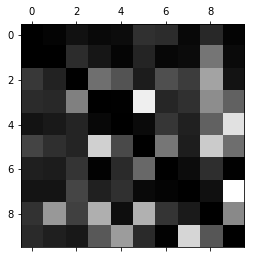

In [26]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

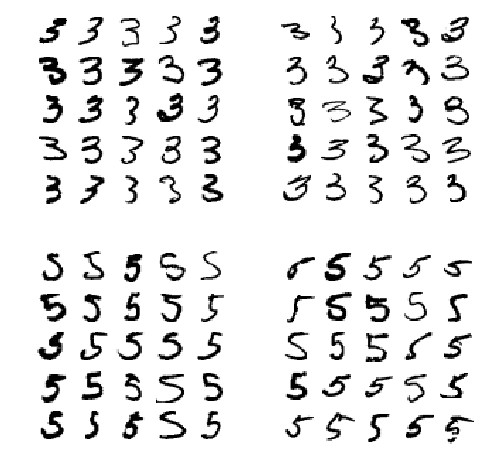

In [27]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


In [28]:
#Multilabel classification
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [29]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv = 3)
#f1_score(y_train, y_train_knn_pred, average= "macro")

In [30]:
print("Done")

Done


In [32]:
#Exercises
#Fine Tuning the model using grid search
#from sklearn.model_selection import GridSearchCV
#from sklearn.neighbors import KNeighborsClassifier
#param_grid = [
#    {'n_neighbors':[2, 3, 4, 5, 6], 'weights': ['uniform', 'distance'], 'p': [1, 2]}]
#knn_clf = KNeighborsClassifier()
#grid_search = GridSearchCV(knn_clf, param_grid, cv = 5)
#grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)